In [16]:
import math
from collections import defaultdict
from itertools import product


import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from pgmpy.factors.discrete import TabularCPD
# from pgmpy.models import BayesianNetwork

#### random variables 

In [17]:
variables = [
    "IsSummer",
    "HasFlu",
    "HasFoodPoisoning",
    "HasHayFever",
    "HasPneumonia",
    "HasRespiratoryProblems",
    "HasGastricProblems",
    "HasRash",
    "Coughs",
    "IsFatigued",
    "Vomits",
    "HasFever",
]
# Nodes

#### create graph

In [18]:
def create_graph():
    G = nx.DiGraph()
    G.add_nodes_from(range(12))
    edges = [
        (0, 1), (0, 2), (0, 3), (0, 4),  # IsSummer -> Diseases
        (1, 8), (1, 9), (1, 11),         # HasFlu -> Coughs, IsFatigued, HasFever
        (2, 6), (2, 10), (2, 11),        # HasFoodPoisoning -> HasGastricProblems, Vomits, HasFever
        (3, 5), (3, 7), (3, 8),          # HasHayFever -> HasRespiratoryProblems, HasRash, Coughs
        (4, 5), (4, 8), (4, 9), (4, 11)  # HasPneumonia -> HasRespiratoryProblems, Coughs, IsFatigued, HasFever
    ]
    G.add_edges_from(edges)
    return G

#### visualize graph

In [19]:
def visualize_graph(G):
    plt.figure(figsize=(12, 8))
    # Use a layered layout for better visualization
    pos = nx.spring_layout(G, seed=42)  # Consistent layout
    # Map node indices to variable names
    labels = {i: variables[i] for i in range(12)}
    nx.draw(
        G,
        pos,
        with_labels=True,
        labels=labels,
        node_color='lightblue',
        node_size=2000,
        font_size=10,
        font_weight='bold',
        arrowsize=20
    )
    plt.title("Bayesian Network for Medical Diagnosis")
    plt.savefig('bayesian_network.png')
    plt.show()

#### Initialize CPTs with random parameters

In [20]:

def initialize_random_cpts(G):
    cpts = {}
    for node in G.nodes:
        parents = list(G.predecessors(node))
        n_parent_configs = 2 ** len(parents)
        # Random probabilities (normalized)
        probs = np.random.rand(n_parent_configs)
        probs /= probs.sum()
        cpts[node] = {
            'parents': parents,
            'probs': probs
        }
    return cpts

#### Load dataset.dat

In [21]:
def load_dataset(filename):
    samples = []
    with open(filename, 'r') as f:
        for line in f:
            sample = int(line.strip())
            samples.append(sample)
    return samples


#### Convert integer to binary assignment

In [22]:

def int_to_assignment(n):
    return [(n >> i) & 1 for i in range(11, -1, -1)]

#### Estimate CPTs from dataset

In [23]:
def estimate_cpts(G, samples):
    cpts = {}
    for node in G.nodes:
        parents = list(G.predecessors(node))
        counts = defaultdict(int)
        parent_counts = defaultdict(int)
        for sample in samples:
            assignment = int_to_assignment(sample)
            parent_config = tuple(assignment[p] for p in parents)
            counts[(parent_config, assignment[node])] += 1
            parent_counts[parent_config] += 1

        n_parent_configs = 2 ** len(parents)
        probs = []
        for parent_vals in product([0, 1], repeat=len(parents)):
            parent_config = tuple(parent_vals)
            true_count = counts[(parent_config, 1)]
            total = parent_counts[parent_config]
            prob = true_count / total if total > 0 else 0.5  
            probs.append(prob)
        cpts[node] = {
            'parents': parents,
            'probs': np.array(probs)
        }
    return cpts

#### Get probability of a full assignment

In [24]:

def get_probability(assignment, cpts):
    prob = 1.0
    for node in range(12):
        parents = cpts[node]['parents']
        parent_vals = tuple(assignment[p] for p in parents)
        parent_idx = sum(v << (len(parents) - 1 - i) for i, v in enumerate(parent_vals))
        p_true = cpts[node]['probs'][parent_idx]
        prob *= p_true if assignment[node] else (1 - p_true)
    return prob

#### Compute L1 distance

In [25]:
def compute_l1_distance(cpts, joint_file):
    true_probs = np.zeros(4096)
    with open(joint_file, 'r') as f:
        for i, line in enumerate(f):
            idx, prob = map(float, line.strip().split())
            true_probs[int(idx)] = prob
    l1 = 0.0
    for i in range(4096):
        assignment = int_to_assignment(i)
        model_prob = get_probability(assignment, cpts)
        l1 += abs(model_prob - true_probs[i])
    return l1

#### Compute KL-divergence

In [26]:
def compute_kl_divergence(cpts, joint_file):
    true_probs = np.zeros(4096)
    with open(joint_file, 'r') as f:
        for i, line in enumerate(f):
            idx, prob = map(float, line.strip().split())
            true_probs[int(idx)] = prob
    kl = 0.0
    for i in range(4096):
        assignment = int_to_assignment(i)
        model_prob = get_probability(assignment, cpts)
        if model_prob > 0 and true_probs[i] > 0:
            kl += true_probs[i] * math.log(true_probs[i] / model_prob)
    return kl

#### Query processing

In [27]:
def query(cpts, observed, query_vars):
    result = defaultdict(float)
    for config in product([0, 1], repeat=12):
        assignment = list(config)
        consistent = all(assignment[k] == v for k, v in observed.items())
        if not consistent:
            continue
        prob = get_probability(assignment, cpts)
        query_config = tuple(assignment[v] for v in query_vars)
        result[query_config] += prob
    # Normalize
    total = sum(result.values())
    if total > 0:
        for k in result:
            result[k] /= total
    return result

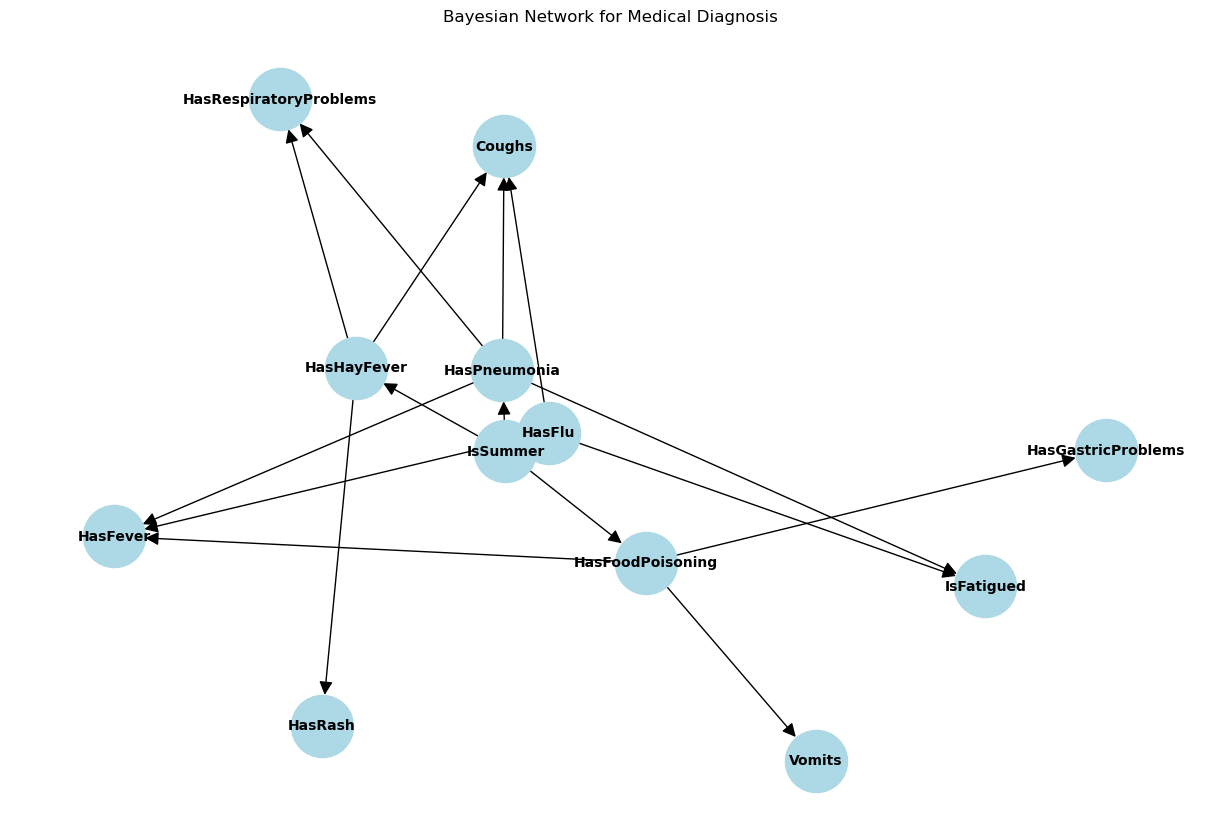

L1 Distance: 0.5484955857240096
KL Divergence: 0.5396617231717316
P(HasFlu | HasFever=True, Coughs=True): 0.09265606436443223
P(HasRash, Coughs, IsFatigued, Vomits, HasFever | HasPneumonia=True):
P(Vomits | IsSummer=True): 0.04637479205861831
P(HasFlu | HasFever=True, HasFoodPoisoning=False): 0.09587946591973866


In [28]:
G = create_graph()
visualize_graph(G)

random_cpts = initialize_random_cpts(G)
samples = load_dataset("./data/dataset.dat")
learned_cpts = estimate_cpts(G, samples)

l1_distance = compute_l1_distance(learned_cpts, "./data/joint.dat")
kl_divergence = compute_kl_divergence(learned_cpts, "./data/joint.dat")
print(f"L1 Distance: {l1_distance}")
print(f"KL Divergence: {kl_divergence}")


# query 1: P(HasFlu | HasFever=True, Coughs=True)
q1 = query(learned_cpts, {11: 1, 8: 1}, [1])
print("P(HasFlu | HasFever=True, Coughs=True):", q1[(1,)])

# query 2: P(Symptoms | HasPneumonia=True)
symptoms = [7, 8, 9, 10, 11]
q2 = query(learned_cpts, {4: 1}, symptoms)
print("P(HasRash, Coughs, IsFatigued, Vomits, HasFever | HasPneumonia=True):")
# for config, prob in q2.items():
#     print(f"Config {config}: {prob}")

# query 3: P(Vomits | IsSummer=True)
q3 = query(learned_cpts, {0: 1}, [10])
print("P(Vomits | IsSummer=True):", q3[(1,)])


# query 4: P(HasFlu | HasFever=True, HasFoodPoisoning=False)
q4 = query(learned_cpts, {11: 1, 2: 0}, [1])
print("P(HasFlu | HasFever=True, HasFoodPoisoning=False):", q4[(1,)])